## Nupack Analysis Code 

nupack-4.0.0.26

Nupack download: http://www.nupack.org/downloads

Nupack documentation: https://piercelab-caltech.github.io/nupack-docs/analysis/

## To use this program, run all the cells in this file until you get to the main interface cell. 

## Find the cell:
##        "Main interface (users input parameters here!)." 
## This is the only cell you will need to change to set up your in silico experiments.



### Helpful Hint: shift+return runs cells

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from itertools import cycle
from datetime import datetime
from nupack import *

Note: As of 14-Feb-2022, the NUPACK web app and the NUPACK python library run on different backend models. 
The python model (herein) is the newest version.

If you want the results of this code to match the NUPACK web app, use the specific model-material designators <br> 'dna04-nupack3' or 'rna95-nupack3'.  
See below.

(NOTE: I suggest using ctr+f to find the correct lines to change. Ex: ctrl + F -> search -> Model(

For DNA <br>
my_model = Model(material='dna04-nupack3', ensemble='some-nupack3', celsius=37)<br>

For RNA:<br>
model1 = Model(material='rna95-nupack3', ensemble='some-nupack3', celsius=37)


# specify strands
A = Strand('CTGATCGAT', name='Strand A')
B = Strand('GATCGTAGTC', name='Strand B')

# specify tube
t1 = Tube(strands={A: 1e-8, B: 1e-9},
    complexes=SetSpec(max_size=2), name='Tube 1') # all complexes of up to 2 strands

# run tube analysis job
my_results = tube_analysis(tubes=[t1], model=model1)
my_results

## Supporting functions 

In [2]:
def make_list(concentration_A):
    """This puts concentration_A in a list.
       Input: Numerical input. Can be list of/or int/float
       Output: list of concentration_A
    """
    if not isinstance(concentration_A, list):
        concentration_A = [concentration_A]
    elif isinstance(concentration_A, list):
        pass
    return concentration_A
    
    
def is_string(nucleic_acid_type):
    """This puts nucleic_acid_type and checks it as a string. CODE 1
       Input: String input. Can be 'rna' or 'dna'
       Output: output is input string
    """
    if not isinstance(nucleic_acid_type, str):
        
        try:
            nucleic_acid_type = str(nucleic_acid_type.lower())
        except:
            print("Check nucleic_acid is a string. (CODE 1)")
            pass
    else:
        pass
    
    return nucleic_acid_type


def print_strands(A,B):
    print("5'-"+str(A)+"-3'")
    print("3'-"+str(B)+"-5'")

    
def is_nucleic_acid(nucleic_acid_string):
    """This puts nucleic_acid_type and checks it as a  A,T,G,C,U . (CODE 2)
       Input: String input. Can be 'rna' or 'dna'
       Output: Warning statement
    """
    nucleic_acid_types = ['A','T','G','C','U']
    if not isinstance(nucleic_acid_string, str):
        print("Your nucleic acid input needs to be a string. Check your inputs.  (CODE 2)")
        nucleic_acid_string = str(nucleic_acid_string)
    
        #are any of these string characters not is my list of nucleobases
    for nucleobase in nucleic_acid_string:
        if nucleobase.upper() not in nucleic_acid_types:
            print(nucleobase + " is not a valid nucleobase")
            print("Your nucleic acid input needs to be a string of ONLY A,T,G,C,U nucleobases. Check your inputs.  (CODE 2)")
        break

        
def report_parameters(Results):
    print(str(len(Results.keys())) + ' number of conditions')
    index = list(Results.keys())
    return index


def report_summary(Results, indexbyNumber):
    index = report_parameters(Results)
    print(index[indexbyNumber])
    return Results[index[indexbyNumber]]


def convertK_to_C(tempK):
    """ Converts temp in kelvin to temp in Celsius
    """
    tempC = tempK-273.14
    return round(tempC)


def print_tempC(temperature_C):
    """Reports number of temperatures being evaluated
        Input: temperature_C
    """
    print("Number of temps: "+str(len(temperature_C)))


def print_tubes(tubes):
    """Reports number of tube conditions being evaluated
        Input: tubes
    """
    tubes_ = make_list(tubes)
    print("Number of tubes: "+str(len(tubes_[0])))   ##### debugging
    
    
def convert_copyNumber2Conc(sampleSize_uL=25, target_number=1000):
    """Gets molar concentration of target in solution
        Input: sampleSize in μL, estimated target molecule amount
        Output: target_concentration molarity (M)
    """
    NA = 6.022e23 # Avogadros number (mol^-1)
#     '{:.2g}'.format(sampleSize)
    sampleSize_L = sampleSize_uL*1e-6 # Convert sample size to L
    target_conc = (target_number/(sampleSize_L))*(1/NA) # convert concentration to molarity
    return float('{:.3g}'.format(target_conc))


def convert_conc2copyNumber(Concentration_M, sampleSize_uL=25):
    """Finds copy number from molarity of target in solution
        Input: sampleSize in μL, estimated target molecule amount
        Output: copy number
    """
    NA = 6.022e23 # Avogadros number (mol^-1)
    sampleSize_L = float(sampleSize_uL)*1e-06 # Convert sample size to L
    copyNumber = float(Concentration_M)*sampleSize_L*NA
    return round(float('{:.1g}'.format(copyNumber)),2)
     
    
def save_fig(fig, name='NUPACK_Results'):
    """ Saviing the figure
        Input: fig object and figure name
        Output: Saved png figure
    """
    date = datetime.now()
    date_str = str(date)[0:-7]
    fig.savefig(name+date_str+'.png',dpi=100,bbox_inches='tight')
    return print("Figure saved")
# save_fig(fig, name)

## Main Functions.


In [160]:
def models_maker(nucleic_acid_type='dna', temperature_C=37, Na_M=0.05, Mg_M=0):
    """Input: material: (DNA as 'dna' or RNA as 'rna'), 
              temperature (C): temperatures to evaluate as list
              sodium [Na+]: in Molarity (M), (Ex: 1e-9) aka 1nM. Minimum = 0.05
              magnesium [Mg++]: in Molarity (M), (Ex: .000001) aka μM 
              Note: This function is set up for only RNA salt concentrations.
              DNA would also need potassium and ammonium. Not sure how to get that functionality
              
       Output: Models for each temperature.
    """
    if not isinstance(Na_M,list):
        if Na_M < 0.05:
            print('Minimum [Na] >= 0.05')
            print('Resetting Na concentration to 0.05 M')
            Na_M = 0.05
        else:
            pass
    elif isinstance(Na_M, list):
        for C_Na in Na_M:
            if C_Na < 0.05:
                print('Minimum [Na] >= 0.05')
                print('Reseting [Na]: ' + str(C_Na) + ' to 0.05 M')
                index = Na_M.index(C_Na)
                Na_M[index] = 0.05
        else:
            pass
            
    else:
        pass
        if not isinstance(Mg_M,list):
            if Mg_M < 0.05:
                print('Minimum [Mg] >= 0.05')
                print('Resetting Mg concentration to 0.05 M')
                Mg_M = 0.05
            else:
                pass
        elif isinstance(Mg_M, list):
            for C_Mg in Mg_M:
                if C_Mg < 0.05:
                    print('Minimum [Mg] >= 0.05')
                    print('Reseting [Mg]: ' + C_Mg + ' to 0.05 M')
                    index = Mg_M.index('C_Mg')
                    Mg_M[index] = 0.05
            else:
                pass

        else:
            pass
        
    oligonucleotide = is_string(nucleic_acid_type).lower()
    models = {} # collection of models based on temperature
    i = 0
    for temp in make_list(temperature_C):
        for conc_Na in make_list(Na_M):
            for conc_Mg in make_list(Mg_M):
                label = str(temp)+'C, '+'Na+: '+str(conc_Na)+'M, '+' Mg++: '+str(conc_Mg)+'M, '
                
                #####  II        IIIII    IIIII   II III     II  II IIIIII IIIIII IIIIII    II
                #####  II       II   II  II   II  IIII       IIIIII II---  II__I  II---     II
                #####  IIIIII    IIIII    IIIII   II III     II  II IIIIII II  II IIIIII    ..
                 
                #####  III    III   IIIII   III   IIIII  II       IIIIIIII  III  II  IIIIII  II  II  IIIIIIII
                #####  II I  I II  II   II  II I  II---  II          II     II I II  II__II  II  II     II
                #####  II  I   II   IIIII   III   IIIII  IIIIII   IIIIIIII  II  III  II      IIIIII     II
                
                # The model below is the must up-to-date 
                models[label] = Model(material=oligonucleotide, celsius=temp, sodium=conc_Na, magnesium=conc_Mg) # salt concentrations in M
                
                # If you want your output to match the NUPACK web app, comment out the model line about and uncomment
                # the line below.
                # FOR DNA
                #models[label] = Model(material='dna04-nupack3', ensemble='some-nupack3', celsius=temp,sodium=conc_Na, magnesium=conc_Mg)
                # FOR RNA
                #models[label] = Model(material='rna95-nupack3', celsius=temp, sodium=conc_Na, magnesium=conc_Mg)
                i+=1

    # check if list
    if not isinstance(temperature_C, list):
        temperature_C = [temperature_C]
    elif isinstance(temperature_C, list): 
        pass 
    else:
        pass
    return models


def specify_strands(fiveprime_strands):  
    """fiveprime_strand: Needs to be string of A's, T's, G's, C's:   (CODE 3)
    """
    if not isinstance(fiveprime_strands, list):   ######################### NEED TO UPDATE FOR MULTIPLE STRANDS ###
        fiveprime_strands = [fiveprime_strands]
        
    if len(fiveprime_strands) == 1:
        fiveprime_strand = fiveprime_strands[0]

        threeprime_strand = ''
        if "U" not in fiveprime_strand and "T" in fiveprime_strand:
            for nb in fiveprime_strand:

                if nb.upper() == 'A':
                    threeprime_strand = threeprime_strand + 'T'
                elif nb.upper() == 'T':
                    threeprime_strand = threeprime_strand + 'A'
                elif nb.upper() == 'G':
                    threeprime_strand = threeprime_strand + 'C'
                elif nb.upper() == 'C':
                    threeprime_strand = threeprime_strand + 'G'
                else:
                    pass

        elif "U" in fiveprime_strand and "T" not in fiveprime_strand:
            for nb in fiveprime_strand:
                if nb.upper() == 'A':
                    threeprime_strand = threeprime_strand + 'U'
                elif nb.upper() == 'U':
                    threeprime_strand = threeprime_strand + 'A'
                elif nb.upper() == 'G':
                    threeprime_strand = threeprime_strand + 'C'
                elif nb.upper() == 'C':
                    threeprime_strand = threeprime_strand + 'G'
                else:
                    pass
        else:
            print('It looks like there is a mix up with RNA and DNA. Check inputs. (CODE 3)')

    elif len(fiveprime_strands) == 2:
        fiveprime_strand = fiveprime_strands[0]
        threeprime_strand = fiveprime_strands[1]
    
    
    #print("[" + fiveprime_strand + ">")
    #print("<" + threeprime_strand + "]")
    #print(" ")
    print("Strand A: ["+fiveprime_strand+">")
    print("Strand B: ["+threeprime_strand[::-1]+">")
   
    A = Strand(fiveprime_strand, name='Strand A')
    B = Strand(threeprime_strand[::-1], name='Strand B')
    
    # print_strands(A,B)
    return A,B

#### NEED TO IMPROVE THIS FUNCTION TO ANALYSE MORE STRANDS
def specify_tube(A, B, concentrations=[1e-09, 3e-09], setSpec=2): # name=''
# def specify_tube(strand_conc_dict, setSpec=2):
    """Inputs: A & B are <Strand Strand A>, can be list, must be same size
               concentrations as molar: e.g. input 1e-9 as 1nm
               setSpec: int(), all complexes of up to 2 strands
               name: string of tube name/number. 
       Output: tube object and complexes object
    """
    # this list is redundant with another function. Maybe make a function.
    strand_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                    'AA','AB','AC','AD','AE','AF','AG','AH','AI','AJ','AK','AL','AM','AN','AO','AP','AQ','AR','AS','AT','AU','AV','AW','AX','AY','AZ',
                    'BA','BB','BC','BD','BE','BF','BG','BH','BI','BJ','BK','BL','BM','BN','BO','BP','BQ','BR','BS','BT','BU','BV','BW','BX','BY','BZ',
                    'CA','CB','CC','CD','CE','CF','CG','CH','CI','CJ','CK','CL','CM','CN','CO','CP','CQ','CR','CS','CT','CU','CV','CW','CX','CY','CZ']
    
    
    dict_of_concentrations = {}
    for i in range(0,len(concentrations)):
        dict_of_concentrations[strand_names[i]] = make_list(concentrations[i])

    concentration_A = dict_of_concentrations['A']
    concentration_B = dict_of_concentrations['B']
    
    
    ########################### THIS NEEDS WORK
#     function Recurse (y, number) 
#        if (number > 1)
#           Recurse ( y, number - 1 )
#        else
#           for x in range (y)
#           whatever()

    tubes = {}
    i = 0 # counter
    for concA in concentration_A:
        for concB in concentration_B:
            tube_name = 'A: '+str(concA)+'M, '+' B: '+str(concB)+'M'
            tubes[str(tube_name)] = Tube(strands={A: concA, B: concB},    ########################### THIS NEEDS WORK
            complexes=SetSpec(max_size=2), name=tube_name) # all complexes of up to 2 strands
            i+=1 
            
    # check if list
#     tubes_ = make_list(tubes)
#     print("Number of tubes: "+str(len(tubes_[0])))   ##### debugging

    print_tubes(tubes)
    return tubes


def analysis_job(tubes, models):
    """Input: tubes: <Tube Tube 1>, can be list of tubes
              models: <nupack.model.Model at XXXX>, can be dictionary
       Output: results from analysis: partition func, ΔG(kcal/mol),concnetration results 
    """
    
    # convert dict or object to list
    if isinstance(models, dict):
        models_list = list(models.values())
    elif not isinstance(models, list):
        models_list = [models]
    else:
        pass
    
    # convert dict or object to list
    if isinstance(tubes, dict):
        tubes_list = list(tubes.values())
    elif not isinstance(tubes, list): 
        tubes_list = [tubes]
    else:
        pass
    
    results = {}
    
    i = 0 # counter
    
    for model in models_list:
        label = str(list(models.keys())[i])
        
        ii = 0
        for tube in tubes_list:
            
            label_full = label + str(list(tubes.keys())[ii])

            # run tube analysis job # Debugging
            # tube = tube[list(tube.keys())[0]] # Debugging
            #model = model[list(model.keys())[0]] # Debugging
            results[label_full] = tube_analysis(tubes=[tube], model=model)
    
            ii += 1
        i += 1
    return results


def run_analysis(strands_input=['ATGC'], nucleic_acid_type='dna', temperature_C=37,
                 Na_M=1, Mg_M=0,  
                 concentrations=[[1e-09], [3e-09]],
                 complex_numb=2):
    
    """Wrapper function for analysis functions
    """
    if not isinstance(strands_input, list):
        strands_input = [strands_input]
    
    # 104 strand input names. Hopefully no one will input more 104 than strands
    strand_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                    'AA','AB','AC','AD','AE','AF','AG','AH','AI','AJ','AK','AL','AM','AN','AO','AP','AQ','AR','AS','AT','AU','AV','AW','AX','AY','AZ',
                    'BA','BB','BC','BD','BE','BF','BG','BH','BI','BJ','BK','BL','BM','BN','BO','BP','BQ','BR','BS','BT','BU','BV','BW','BX','BY','BZ',
                    'CA','CB','CC','CD','CE','CF','CG','CH','CI','CJ','CK','CL','CM','CN','CO','CP','CQ','CR','CS','CT','CU','CV','CW','CX','CY','CZ']
    
    # Build models
    models = models_maker(nucleic_acid_type, temperature_C, Na_M, Mg_M) # rna or dna, temp, salt
    
    #print(len(strands_input))
    strand_dict = {}
    if len(strands_input) <= 2:
        # Build complement strand
        A, B = specify_strands(strands_input[0])
        strand_dict = {A: concentrations[0][0], B: concentrations[1][0]}
    
#     elif len(strands_input) == 2:        
#         A = Strand(strands_input[0], name='Strand A')
#         B = Strand(strands_input[1], name='Strand B')
        
    else:
        
        for i in range(0,len(list(strands))):
            # Build a dictionary of all the input strands
            strand_dict[Strand(strands_input[i], name='Strand ' + strand_names[i])] = concentrations[i]
            
      ############# NEED to UPDATE HERE FOR MULTIPLE STRAND FUNCTIONALITY      
            
    # Build test tubes
#     tubes = Tube(strands=strand_dict,
#                complexes=SetSpec(max_size=2),
#                     name='tube')     
    
#     t2 = Tube(strands={A: 1e-10, B: 1e-9}, complexes=SetSpec(max_size=2), name='t2')
#     # Build test tubes
#     Tube(strands={A: 1e-6, B: 1e-8, C: 1e-12},
#          complexes=SetSpec(max_size=complexes))
    
    # Build test tubes
#     tubes = specify_tube(strand_dict, setSpec=complexes) #######
    tubes = specify_tube(A, B, concentrations, setSpec=complexes) 
#     tube_analysis 
    return analysis_job(tubes, models)
#     return tube_analysis(tubes, models)


def make_dataFrame_from_results(Results=pd.DataFrame()): 
    """This function creates a simple dataframe from the Nupack query data. 
        This function is currently static, and should be rewritten to generalize. 
        Inputs: Results from make_dataFrame_from_results()
    """
    column_names = ['Material',
                    'TemperatureC',
                    'Na_molarity (M)',
                    'Mg_molarity (M)',
                    'Complex A Conc (M)',
                    'Complex B Conc (M)',
                    'Complex AA Conc (M)',
                    'Complex AB Conc (M)',
                    'Complex BB Conc (M)',
                    'ΔG A kcal/mol',
                    'ΔG B kcal/mol',
                    'ΔG AA kcal/mol',
                    'ΔG AB kcal/mol',
                    'ΔG BB kcal/mol',                 
                    'Partition func A kcal/mol',
                    'Partition func B kcal/mol',    
                    'Partition func AA kcal/mol',
                    'Partition func AB kcal/mol',
                    'Partition func BB kcal/mol']

    df = pd.DataFrame(columns = column_names)

    for i in range(0,len(list(Results.keys()))):

        t_result = Results[list(Results.keys())[i]].tubes 
        c_result = Results[list(Results.keys())[i]].complexes 

        # dir(c_result[list(c_result.keys())[0]].model) # Debugging
        
        free_energy_B  = '{:.2g}'.format(c_result[list(c_result.keys())[0]].free_energy)
        free_energy_A  = '{:.2g}'.format(c_result[list(c_result.keys())[1]].free_energy)
        free_energy_AA = '{:.2g}'.format(c_result[list(c_result.keys())[2]].free_energy)
        free_energy_AB = '{:.2g}'.format(c_result[list(c_result.keys())[3]].free_energy)
        free_energy_BB = '{:.2g}'.format(c_result[list(c_result.keys())[4]].free_energy)

        pfunc_B  = '{:.2g}'.format(c_result[list(c_result.keys())[0]].pfunc)
        pfunc_A  = '{:.2g}'.format(c_result[list(c_result.keys())[1]].pfunc)
        pfunc_AA = '{:.2g}'.format(c_result[list(c_result.keys())[2]].pfunc)
        pfunc_AB = '{:.2g}'.format(c_result[list(c_result.keys())[3]].pfunc)
        pfunc_BB = '{:.2g}'.format(c_result[list(c_result.keys())[4]].pfunc)

        # Other options
    #     mfe_B  = c_result[list(c_result.keys())[0]].mfe
    #     mfe_A  = c_result[list(c_result.keys())[1]].mfe
    #     mfe_AA = c_result[list(c_result.keys())[2]].mfe
    #     mfe_AB = c_result[list(c_result.keys())[3]].mfe
    #     mfe_BB = c_result[list(c_result.keys())[4]].mfe

        material = c_result[list(c_result.keys())[0]].model.material
        
        temperatureK = c_result[list(c_result.keys())[0]].model.temperature # In kelvin
        temperatureC = convertK_to_C(temperatureK)

        Na_molarity = c_result[list(c_result.keys())[0]].model.conditions.na_molarity
        Mg_molarity = c_result[list(c_result.keys())[0]].model.conditions.mg_molarity

        # Helpful Note:
        # 0 index is complex B
        # 1 index is complex A
        # 2 index is complex A+A
        # 3 index is complex A+B
        # 4 index is complex B+B
        
        concentrations = t_result[list(t_result.keys())[0]].complex_concentrations # iteratable
        
        complex_A  = '{:.3g}'.format(concentrations[list(concentrations.keys())[2]])
        complex_B  = '{:.3g}'.format(concentrations[list(concentrations.keys())[1]])
        complex_AA = '{:.3g}'.format(concentrations[list(concentrations.keys())[3]])
        complex_BB = '{:.3g}'.format(concentrations[list(concentrations.keys())[0]])
        complex_AB = '{:.3g}'.format(concentrations[list(concentrations.keys())[4]])


        df.loc[i]=[material, temperatureC, Na_molarity, Mg_molarity,
                   complex_A, complex_B, complex_AA, complex_AB, complex_BB,
                   free_energy_A, free_energy_B, free_energy_AA, free_energy_AB, free_energy_BB,
                   pfunc_A, pfunc_B, pfunc_AA, pfunc_AB, pfunc_BB]
    return df, t_result, c_result


# Building a dictionary of each experimental database
def make_sorted_df(df_Nupack, concentrations):
    """This function is used to get and sort the same experimental conditions in the df_Nupack
        dataframe, and make a new simple dataframe to be used with plotting. The plotting is 
        specifically set up for "TempC","percent_bound_A","percent_bound_B","AB_Conc_M", "A_Conc_M", "B_Conc_M" 
        but this can be changed at a later date.
        Input: df_Nupack- dataframe of nupack results
        Output: Dataframe of sorted chosen data
    """
    
    
    concentration_A = make_list(concentrations[0])
    concentration_B =  make_list(concentrations[1])
    
    # making the column names easier to handle.
    column_names = ['Material',
                    'TempC',
                    'Na_M',
                    'Mg_M',
                    'A_Conc_M',
                    'B_Conc_M',
                    'AA_Conc_M',
                    'AB_Conc_M',
                    'BB_Conc_M',
                    'ΔG_A',
                    'ΔG_B',
                    'ΔG_AA',
                    'ΔG_AB',
                    'ΔG_BB',                 
                    'Pfunc_A',
                    'Pfunc_B',    
                    'Pfunc_AA',
                    'Pfunc_AB',
                    'Pfunc_BB']

    df_Nupack.columns = column_names # setting column names
    
    conditions = len(df_Nupack.TempC.unique())#+len(df_Nupack.Na_M.unique()+len(df_Nupack.Mg_M.unique()
    dfsize = int(df_Nupack.shape[0])
    unique_rows = int(dfsize/conditions)

    sorted_df_Nupack = {}
    for i in range(0,unique_rows):
        sorted_df_Nupack[i] = df_Nupack.iloc[i::unique_rows, :] # Splicing out rows for each experiment

    temp_concBound = {}

    # Building a new sorted & simple dictionary for plotting
    # Also adding percent bound of species
    for i in range(0,len(sorted_df_Nupack)):
        sorted_df_Nupack[i].reset_index(inplace = True)
        
        # Making new dataframe to store data I want to graph
        df_temp_concBound = pd.DataFrame(columns = ["TempC",
                                                    "Na_M",
                                                    "Mg_M",
                                                    "percent_bound_A",
                                                    "percent_bound_B",
                                                    "AB_Conc_M", 
                                                    "A_Conc_M", 
                                                    "B_Conc_M" ])
        
        for iii in range(0,len(concentration_A)):  # this for loop cycles through the concentrations of A
            ## Iterating over each set of ordered experiments
            for ii in range(0,len(sorted_df_Nupack[i])):
                TempC = sorted_df_Nupack[i]["TempC"][ii]
                Na_M = sorted_df_Nupack[i]["Na_M"][ii]
                Mg_M = sorted_df_Nupack[i]["Mg_M"][ii]
                AB_Conc_M = float(sorted_df_Nupack[i]["AB_Conc_M"][ii])
                
                A_Conc_M = float(sorted_df_Nupack[i]["A_Conc_M"][ii])
                B_Conc_M = float(sorted_df_Nupack[i]["B_Conc_M"][ii])

                # Note: This is an important operation for the outcome of this code  ###################################
                # These are the percent bound [AB/A] and [AB/B]            
                percent_bound_A = ((AB_Conc_M)/float(concentration_A[iii]))*100 # [AB/A] 
                percent_bound_B = ((AB_Conc_M)/float(concentration_B[0]))*100 # [AB/B] 


                ## Writing new row in the concentration bound dataframe
                df_temp_concBound.loc[ii] = [TempC, Na_M, Mg_M, percent_bound_A, percent_bound_B, AB_Conc_M, A_Conc_M, B_Conc_M]

            # Dictonary for df_temp_concBound values
            temp_concBound[i] = df_temp_concBound
    
    return temp_concBound 


def plot_experiment(temp_concBound, concentration_A, sampleVolume_uL, targetAmount, species="B"):
    """This function plots the analyzed results found from Nupack
        Input: dictionary of temperatures and % bound species, sample volume in μL, 
               target molc amount
        Output: Plot of results
    """

    # handling species input
    if species.upper() == "B":
        dependent_var = 'Percent bound [AB]/[B$]_{0}$'
        bound_species = "percent_bound_B"        
        
    else:
        dependent_var = "Percent bound [AB]/[A]"
        bound_species = "percent_bound_A"

    # Custom title
    if species == "B":
        nout = "o"
    else:
        nout = ""
    title_seg1 = ("Percent bound ([AB]/["+str(species)+"$]_{0}$" + "). " + str("{:.2e}".format(targetAmount)) + " copies of target in " + 
             str(sampleVolume_uL) + " μL")
    
    
    fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=1)

    colors = cycle(['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple',
                    'tab:pink', 'tab:cyan', 'tab:olive', 'tab:brown', 'k'])
    
####


##
    for i in range(0, len(temp_concBound)):
        
        Na_M = temp_concBound[i]["Na_M"]
        Mg_M = temp_concBound[i]["Mg_M"]
        
        flag_1 = True # A generic boolian for formatting new lines in the title bar
        ions = ''
        
        if len(np.unique(Na_M.squeeze())) == 1:
            title_seg2 = '   $Na^+ (M): $' + str(Na_M[i])
#             ions = ions + title_seg2 # part of legend label for Na salts
            
            title = title_seg1 +'.'+ '\n' +  title_seg2
        else:
            flag_1 = False
            ions = ions + title_seg2 # part of legend label for Na salts
            title_seg2 = '   $Na^+ (M): $' + ', '.join(map(str, list(Na_M.squeeze().unique())))
            title = title_seg1 + '\n'+ title_seg2

    
        if len(np.unique(Mg_M.squeeze())) == 1 and flag_1 == True:
            title_seg3 = ' $Mg^{++} (M): $' +  str(Mg_M[i])
            
#             ions = ions + title_seg3 # part of legend label for Na salts
            title = title + '\n' +  title_seg3
        else:
            ions = ions + title_seg3 # part of legend label for Na salts
            title = title + '\n'+ '$Mg^{++} (M): $' + ', '.join(map(str, list(Mg_M.squeeze().unique())))         
    
        legend_label = 'Probe Conc: '+str(concentration_A[i])+' M. '+ions
        
        X = temp_concBound[i]["TempC"]
        Y = (temp_concBound[i][bound_species])
        axes.plot(X,Y, color=next(colors) ,markersize=8, marker='o',fillstyle='none', linewidth=2, label=legend_label)
    axes.set_xlabel('Temperature [C]',fontsize=16)
    axes.set_ylabel(dependent_var,fontsize=16)
    axes.set_title(title,fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large')

    fig.tight_layout()
    plt.show()
    return fig


def run_all(fiveprime_strand='ATGC', nucleic_acid_type='dna', temperature_C=37, sampleVolume_uL=25,
                    concentrations=[1e-09,3e-09],
                    Na_M=1, Mg_M=0,  
                    complexes=2,
                    species="A", savefig="no_save"):
    """Wrapper function for the entire nupack project.
    """
    
    
    concentration_A = make_list(concentrations[0])
    concentration_B = make_list(concentrations[1])
    
#     print('concentration_B' + str(concentration_B))
#     print(temperature_C)
    Results = run_analysis(fiveprime_strand, nucleic_acid_type, temperature_C,
                       Na_M, Mg_M,
                       concentrations, complexes)

    print(report_parameters(Results)[0][5:]) # Displays results and information
    
    df_Nupack, t_result, c_result = make_dataFrame_from_results(Results)  ###################################
    
    temp_concBound = make_sorted_df(df_Nupack, concentrations)
    
    targetAmount = convert_conc2copyNumber(concentration_B[0], sampleVolume_uL)
    
##### Comment out plotting for debugging    
    fig = plot_experiment(temp_concBound, concentration_A, sampleVolume_uL, targetAmount, species)
    
    if savefig.lower() == "save":
        save_fig(fig)
    else:
        pass 
    
    return Results, df_Nupack, temp_concBound, t_result, c_result



# Final product

### Putting all this together


# Main interface (users input parameters here!)

Type in your parameters here and run the cell to get your results.



* ####  Fiveprime_strand: Your strand (Note: right now the 3' stand is automatically generated)
* #### Nucleic acid type: RNA or DNA
* #### Temperature start (˚C)
* #### Temperature stop (˚C)
* #### Temperature interval (˚C)
* #### Concentration A (M): Probe
* #### Sample volume (μL)
* #### Target/template copy number
* #### Sodium concentration (M). Does not yet have list compatibility.
* #### Magnesium concentration (M). Does not yet have list compatibility.
* #### Species: Use "A" for percent bound probe
* #### Species: Use "B" for percent bound target/template
* #### Saving figures: If you want to save include "save", otherwise it doesn't matter what you put.


Strand A: [GTTGTATATAGGCCGGCATGTCCGTACACTGGAGGGATGATGATCTCGTGGATGGGCATCGCGGACTTAGATTCTAC>
Strand B: [GTAGAATCTAAGTCCGCGATGCCCATCCACGAGATCATCATCCCTCCAGTGTACGGACATGCCGGCCTATATACAAC>
Number of tubes: 1
22 number of conditions
Na+: 0.5M,  Mg++: 0.1M, A: 1e-08M,  B: 6.64e-08M


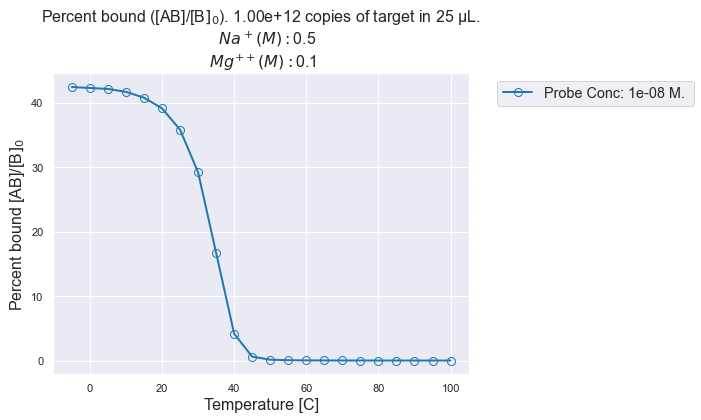

Figure saved


In [161]:
# Insert your sequence here! NOTE: You do not need to type in a complementary strand_2 ...
# ... if the second strand is fully complementary to the first.
# Strand A  5'- 3'
# Strand B  5'- 3'      Note: Nupack web app is 5'- 3' for both inputs
strand_A = 'GTTGTATATAGGCCGGCATGTCCGTACACTGGAGGGATGATGATCTCGTGGATGGGCATCGCGGACTTAGATTCTAC'  # primer or probe  ####  Input here
strand_B = 'GTAGAATCTAAGTCCGCGATGCCCATCCACGAGATCATCATCCCTCCAGTGTACGGACATGCCGGCCTATATACAAC'  # target/template

strands = [strand_A, strand_B]
#strands = [strand_A]     
nucleic_acid_type ='DNA'    ####  Input here

temp_startC = -5            ####  Input here
temp_stopC = 100            ####  Input here
temp_intervalC = 5          ####  Input here

temperatureC = list(range(temp_start,temp_stop+1,temp_interval))

# Concentrations in M
#concentration_A_M = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]#, 1e-15, 1e-16, 1e-17] # Capture probe
concentration_A_M = [1e-8] # 1e-2 μM
# concentration_B_M = [1e-9, 2e-9, 3e-9, 5e-9] # Target



sampleVolume_uL = 25        ####  Input here
targetCopyNumber = 1e12     ####  Input here

# Don't change! This code assumes you are inputting the target copy number.
# If you know the exact concentration(s), make a list and add them into the 
# concentrations list variable below.
concentration_B_M = [convert_copyNumber2Conc(sampleVolume_uL,targetCopyNumber)] # Default: Target 1000 DNA/RNA's in 25μL

concentrations = [concentration_A_M, concentration_B_M]

# Na:  MIN: 0.05  MAX value: 1.1
Na_M = [0.5]                 ####  Input here

# Mg:  MIN: 0.0   MAX value: 0.2
Mg_M = [0.1]                 ####  Input here

species = "B"                ####  Input here
complexes = 2                ####  Input here

# run_all() # Works with no inputs for default values.

Results, df_Nupack, temp_concBound, t_result, c_result = run_all(strands, 
                                                                 nucleic_acid_type, 
                                                                 temperatureC, 
                                                                 sampleVolume_uL,
                                                                 concentrations,
                                                                 Na_M, Mg_M,
                                                                 complexes,
                                                                 species,"Save")


In [159]:
# Quick double check
print('NUPACK Python 0℃ : ' + str(float(df_Nupack.iloc[1,[7]])/concentration_B_M[0]*100))
print('NUPACK web app 0℃ : ' + str((2.800648e-08/6.6400000e-08)*100))



NUPACK Python 0℃ : 42.16867469879518
NUPACK web app 0℃ : 42.17843373493976


In [158]:
# Check specific outputs in the output dataFrame
df_Nupack.iloc[:,[1,4,5,6,7,8]]
#df_Nupack.iloc[[9],[1,4,5,6,7,8]]

,TempC,A_Conc_M,B_Conc_M,AA_Conc_M,AB_Conc_M,BB_Conc_M
0,-5,4.26e-104,1.74e-10,4.28e-199,2.81e-08,1e-08
1,0,2.46e-99,3.87e-10,1.61e-190,2.8e-08,1e-08
2,5,1.36e-94,8.58e-10,5.89e-182,2.78e-08,1e-08
3,10,6.95e-90,1.94e-09,2.06e-173,2.72e-08,1e-08
4,15,3.24e-85,4.6e-09,7.43e-165,2.59e-08,1e-08
5,20,1.4e-80,1.14e-08,3.14e-156,2.25e-08,1e-08
6,25,6.19e-76,2.67e-08,1.83e-147,1.48e-08,1e-08
7,30,3.54e-71,4.63e-08,2.07e-138,5.03e-09,1e-08
8,35,2.78e-66,5.45e-08,4.87e-129,9.25e-10,1e-08
9,40,2.26e-61,5.6e-08,1.38e-119,1.91e-10,1e-08


In [130]:
# Check the entire output dataFrame
df_Nupack.iloc[:,:]

,Material,TempC,Na_M,Mg_M,A_Conc_M,B_Conc_M,AA_Conc_M,AB_Conc_M,BB_Conc_M,ΔG_A,ΔG_B,ΔG_AA,ΔG_AB,ΔG_BB,Pfunc_A,Pfunc_B,Pfunc_AA,Pfunc_AB,Pfunc_BB
0,DNA,-5,0.5,0.1,4.26e-104,1.74e-10,4.28e-199,2.81e-08,1e-08,-23,-1.8e+02,-27,-66,-62,3.7e+18,1.3e+147,4.5e+21,2.6e+53,7.2e+50
1,DNA,0,0.5,0.1,2.46e-99,3.87e-10,1.61e-190,2.8e-08,1e-08,-20,-1.7e+02,-25,-61,-57,2.4e+16,5.9e+137,4.3e+19,2.7e+48,5.9e+45
2,DNA,5,0.5,0.1,1.36e-94,8.58e-10,5.89e-182,2.78e-08,1e-08,-18,-1.6e+02,-23,-56,-52,2.2e+14,6.2e+128,5.8e+17,6.0e+43,1.0e+41
3,DNA,10,0.5,0.1,6.95e-90,1.94e-09,2.06e-173,2.72e-08,1e-08,-16,-1.6e+02,-21,-51,-47,3.0e+12,1.3e+120,1.1e+16,2.8e+39,3.6e+36
4,DNA,15,0.5,0.1,3.24e-85,4.6e-09,7.43e-165,2.59e-08,1e-08,-14,-1.5e+02,-19,-47,-43,5.8e+10,5.8e+111,2.7e+14,2.9e+35,2.2e+32
5,DNA,20,0.5,0.1,1.4e-80,1.14e-08,3.14e-156,2.25e-08,1e-08,-12,-1.4e+02,-17,-43,-38,1.6e+9,5.0e+103,8.9e+12,7.0e+31,2.5e+28
6,DNA,25,0.5,0.1,6.19e-76,2.67e-08,1.83e-147,1.48e-08,1e-08,-11,-1.3e+02,-16,-39,-34,6.7e+7,8.2e+95,3.7e+11,3.6e+28,5.1e+24
7,DNA,30,0.5,0.1,3.54e-71,4.63e-08,2.07e-138,5.03e-09,1e-08,-9.1,-1.2e+02,-14,-35,-30,3.9e+6,2.5e+88,1.9e+10,3.2e+25,2.0e+21
8,DNA,35,0.5,0.1,2.78e-66,5.45e-08,4.87e-129,9.25e-10,1e-08,-7.8,-1.1e+02,-13,-32,-26,3.3e+5,1.4e+81,1.2e+9,4.6e+22,1.9e+18
9,DNA,40,0.5,0.1,2.26e-61,5.6e-08,1.38e-119,1.91e-10,1e-08,-6.6,-1.1e+02,-11,-29,-22,3.8e+4,1.4e+74,8.3e+7,1.0e+20,4.9e+15
